In [8]:
#调用包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
data=pd.read_excel("World.xlsx")
print(data[data.isnull().T.any()])
print("---------------------------------")
data

Empty DataFrame
Columns: [日期, 累计确诊, 治愈人数, 死亡人数]
Index: []
---------------------------------


,日期,累计确诊,治愈人数,死亡人数
0,2020-01-26,2011,51,56
1,2020-01-27,2785,60,82
2,2020-01-28,5344,103,131
3,2020-01-29,5908,126,133
4,2020-01-30,7893,171,171
...,...,...,...,...
456,2021-04-26,22840826,121911107,3120469
457,2021-04-27,22755774,122826142,3134956
458,2021-04-28,22914640,123557549,3150675
459,2021-04-29,22874247,124480554,3165665


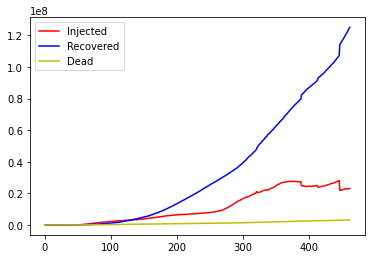

In [10]:
x=list(range(1,data.shape[0]+1))
y1=data['累计确诊'].tolist()
y2=data['治愈人数'].tolist()
y3=data['死亡人数'].tolist()
plt.plot(x,y1,'r',label='Injected')
plt.plot(x,y2,'b',label='Recovered')
plt.plot(x,y3,'y',label='Dead')
plt.legend()
plt.show()

In [11]:
def delta_s(beta,s,i,n,alpha):
    return (-beta*s*i/n-alpha*s)
def delta_e(beta,s,i,n,r1,e):
    return (beta*s*i/n-r1*e)
def delta_i(r1,e,r2d,r2r,i):
    return r1*e-r2d*i-r2r*i
def delta_r(r2r,i,alpha,s):
    return r2r*i+alpha*s
def delta_d(r2d,i):
    return r2d*i
def count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n;alpha=alpha
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(30):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def loss(beta,r1,e0,r2d,r2r,alpha):
    n=7585204179#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    alpha=alpha
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[:31,1].tolist())
    Recovered_true=np.array(data.iloc[:31,2].tolist())
    Dead_true=np.array(data.iloc[:31,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss

In [12]:
import random
import math
import matplotlib.pyplot as plt
#初始化生成chromosome_length大小的population_size个个体的二进制基因型种群
def species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]
def translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_e0=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,50):
            temp_e0+=population[i][j]*(math.pow(2,j-30))
        for j in range(50,65):
            temp_r2d+=population[i][j]*(math.pow(2,j-50))/32768.0
        for j in range(65,80):
            temp_r2r+=population[i][j]*(math.pow(2,j-65))/32768.0
        for j in range(80,95):
            temp_alpha+=population[i][j]*(math.pow(2,j-80))/32768.0
        total=[temp_beta,temp_r1,temp_e0,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def function(temporary):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=loss(temporary[i][0],temporary[i][1],temporary[i][2],temporary[i][3],temporary[i][4],temporary[i][5])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def sum(fitness1):
    total=0
    for i in range(len(fitness1)):
        total+=fitness1[i]
    return total
def newborn(population,born_size,chromosome_length):
    population=population
    #二维列表，包含染色体和基因
    for i in range(born_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

In [13]:
def random_pick(some_list,probabilities,size):
    item_list=[]
    i=0
    while i<size:
        for item,item_probability in zip(some_list,probabilities):
            x=random.uniform(0,1)
            cumulative_probability=item_probability
            if x < cumulative_probability:
                item_list.append(item)
                i=i+1
    return item_list

def selection(population,next_size,fitness1):
    new_fitness=[]
    #单个适应度暂存器
    total_fitness=sum(fitness1)
    #将所有的适应度求和
    for i in range(len(fitness1)):
        new_fitness.append(fitness1[i]/total_fitness)
    select=random_pick(list(range(len(new_fitness))),new_fitness,next_size)
    result=[]
    for i in select:
        result.append(population[i])
    return result

In [14]:
def crossover(population):
#pc是概率阈值，选择单点交叉还是多点交叉，生成新的交叉个体，这里没用
    pop_len=len(population)

    for i in range(pop_len-1):
        cpoint=random.randint(0,len(population[0]))
        #在种群个数内随机生成单点交叉点
        temporary1=[]
        temporary2=[]

        temporary1.extend(population[i][0:cpoint])
        temporary1.extend(population[i+1][cpoint:len(population[i])])
        #将tmporary1作为暂存器，暂时存放第i个染色体中的前0到cpoint个基因，
        #然后再把第i+1个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面

        temporary2.extend(population[i+1][0:cpoint])
        temporary2.extend(population[i][cpoint:len(population[i])])
        # 将tmporary2作为暂存器，暂时存放第i+1个染色体中的前0到cpoint个基因，
        # 然后再把第i个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面
        population[i]=temporary1
        population[i+1]=temporary2
    return population
def mutation(population,pm):
    # pm是概率阈值
    px=len(population)
    # 求出种群中所有个体的个数
    py=len(population[0])
    # 染色体/个体中基因的个数
    for i in range(px):
        if(random.random()<pm):
        #如果小于阈值就变异
            mpoint=random.randint(0,py-1)
            # 生成0到py-1的随机数
            if(population[i][mpoint]==1):
            #将mpoint个基因进行单点随机变异，变为0或者1
                population[i][mpoint]=0
            else:
                population[i][mpoint]=1
    return population

In [15]:
def best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def next_best(population,fitness1,temp_individual,temp_fitness):

    px=len(population)
    bestindividual=temp_individual
    bestfitness=temp_fitness

    for i in range(0,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]

In [16]:
population_size=500
chromosome_length=95
population=species_origin(population_size,chromosome_length)
results=[]
pm=0.5
for m in range(300):
    temporary=translation(population)
    fitness1=function(temporary)
    if m==0:
        best_individual,best_fitness=best(population,fitness1)
    else:
        best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
    print(10000000/best_fitness)
    results.append([best_fitness,best_individual])
     #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
    population=selection(population,450,fitness1)#选择
    population=crossover(population)#交配
    population=mutation(population,pm)#变异
    population=newborn(population,50,95)

1.8636526373817647e+19
3.331885476105983e+16
8075895036076808.0
6785097251999.592
314851751273.0771
108005555115.15845
73687729260.0796
60917654944.87272
52297775909.43772
51419235643.055046
51059960367.983864
49730438897.622696
49730438897.622696
49730438897.622696
49730438897.622696
49011557878.24764
47469812508.786545
43862577175.58915
43862577175.58915
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
43390124786.55104
42640314591.10579
42640314591.10579
42640314591.10579
42640314591.10579
42129689853.97178
41851044177.82008
41851044177.82008
41851044177.82008
41851044177.82008
41851044177.82008
41851044177.82008
41851044177

In [17]:
best=[]
best.append(best_individual)
print(best_individual)
print(translation(best))
print(10000000/best_fitness)

[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.003509521484375, 0.014129638671875, 236430.0, 0.00244140625, 0.0224609375, 0.0]]
1353074748.6743028


In [18]:
first=translation(best)

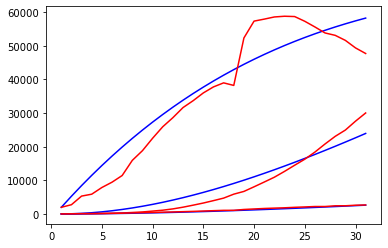

In [19]:
def yuce(beta,r1,e0,r2d,r2r,alpha):
    n=7585204179#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
predict=yuce(first[0][0],first[0][1],first[0][2],first[0][3],first[0][4],first[0][5])
Inject_predict=np.array(predict['累计确诊'].tolist())
Recovered_predict=np.array(predict['治愈人数'].tolist())
Dead_predict=np.array(predict['死亡人数'].tolist())
Inject_true=np.array(data.iloc[:31,1].tolist())
Recovered_true=np.array(data.iloc[:31,2].tolist())
Dead_true=np.array(data.iloc[:31,3].tolist())
x=list(range(1,len(Inject_predict)+1))
plt.plot(x,Inject_predict,'b')
plt.plot(x,Inject_true,'r')
plt.plot(x,Recovered_predict,'b')
plt.plot(x,Recovered_true,'r')
plt.plot(x,Dead_predict,'b')
plt.plot(x,Dead_true,'r')
plt.show()

In [20]:
predict

,S,E,累计确诊,治愈人数,死亡人数
0,7.584966e+09,236430.000000,2011.000000,51.000000,56.000000
1,7.584966e+09,233096.386955,5301.591858,96.168945,60.909668
2,7.584966e+09,229821.424697,8463.137518,215.247669,73.853007
3,7.584966e+09,226603.831635,11499.679249,405.337672,94.514964
4,7.584966e+09,223442.358474,14415.140546,663.631248,122.590353
5,7.584965e+09,220335.787339,17213.329550,987.408819,157.783567
6,7.584965e+09,217282.930926,19897.942362,1374.036338,199.808298
7,7.584965e+09,214282.631681,22472.566265,1820.962778,248.387259
8,7.584965e+09,211333.760992,24940.682854,2325.717685,303.251922
9,7.584965e+09,208435.218416,27305.671078,2885.908803,364.142261


In [21]:
def month_species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

def month_translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,45):
            temp_r2d+=population[i][j]*(math.pow(2,j-30))/32768.0
        for j in range(45,60):
            temp_r2r+=population[i][j]*(math.pow(2,j-45))/32768.0
        for j in range(60,75):
            temp_alpha+=population[i][j]*(math.pow(2,j-60))/32768.0
        total=[temp_beta,temp_r1,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def month_loss(beta,r1,e0,r2d,r2r,month,alpha):
    n=7585204179#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss
def month_function(temporary,e0,month):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=month_loss(temporary[i][0],temporary[i][1],e0,temporary[i][2],temporary[i][3],month,temporary[i][4])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def month_best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def month_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=7585204179#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
def month_yichuan(e0,month):
    population_size=500
    chromosome_length=75
    population=month_species_origin(population_size,chromosome_length)
    results=[]
    pm=0.5
    for m in range(300):
        temporary=month_translation(population)
        fitness1=month_function(temporary,e0,month)
        if m==0:
            best_individual,best_fitness=month_best(population,fitness1)
        else:
            best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
        print(10000000/best_fitness)
        results.append([best_fitness,best_individual])
         #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
        population=selection(population,450,fitness1)#选择
        population=crossover(population)#交配
        population=mutation(population,pm)#变异
        population=newborn(population,50,75)
    mybest=[]
    mybest.append(best_individual)
    print(best_individual)
    print(month_translation(mybest))
    first=month_translation(mybest)
    predict=month_yuce(first[0][0],first[0][1],e0,first[0][2],first[0][3],month,first[0][4])
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    x=list(range(1,len(Inject_predict)+1))
    plt.figure(1)
    plt.plot(x,Inject_predict,'b')
    plt.plot(x,Inject_true,'r')
    plt.figure(2)
    plt.plot(x,Recovered_predict,'b')
    plt.plot(x,Recovered_true,'r')
    plt.figure(3)
    plt.plot(x,Dead_predict,'b')
    plt.plot(x,Dead_true,'r')
    plt.show()
    return predict

157505.19560401322
3.2739348504405108e+16
2873589343277.465
1132766104456.5093
1132766104456.5093
1124604596821.6597
1115668569226.8867
1101317884174.5986
1080788952478.8792
1077576252450.791
1076108935611.5006
1028395674921.5831
1001670936411.4745
1001670936411.4745
1001670936411.4745
981119170131.64
975895577084.8512
958496344593.9465
958496344593.9465
958496344593.9465
945568200425.5005
945568200425.5005
945568200425.5005
945568200425.5005
893435568638.5765
695468127693.6074
695468127693.6074
691638387470.9443
691638387470.9443
691638387470.9443
690796395218.7986
690796395218.7986
683679919552.1879
683679666255.0044
683679666255.0044
683679666255.0044
683679666255.0044
683679666255.0044
683679666255.0044
682872112724.4844
678485923617.2377
678485923617.2377
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.1111
641561441199.

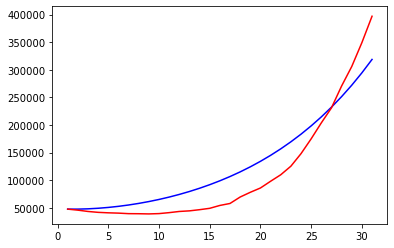

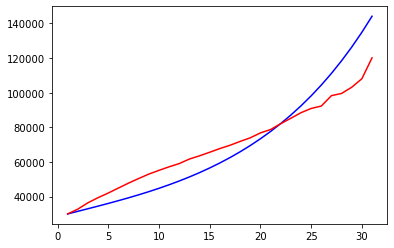

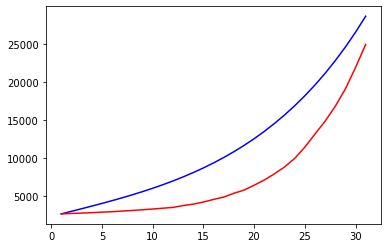

In [22]:
e0=predict.iloc[30,1]
print(e0)
i=0
predict.to_csv('third_predict'+str(i)+'.csv',index=False)
predict=month_yichuan(e0,1)
i=1
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.2027104705540812e+16
587576286814626.2
51705298975642.766
51178769765389.58
49693090726305.07
49608057549623.04
49608057549623.04
49579181397043.63
49498878239812.73
45659146995422.88
44419837069325.72
44419837069325.72
44419837069325.72
44419837069325.72
44419837069325.72
44341382411445.94
44341382411445.94
44341382411445.94
44245261433077.086
44245261433077.086
44245261433077.086
43774905646478.234
43774905646478.234
43774905646478.234
43774905646478.234
43774905646478.234
43774905646478.234
43774905646478.234
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
40791495150576.96
39113506909253.28
39113506909253.28
39113506909253.28
37615000370015.98
37615000370015.98
37615000370015.98
364197391196

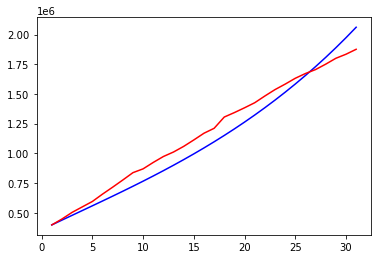

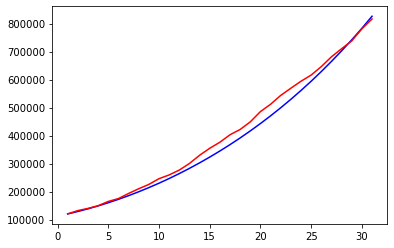

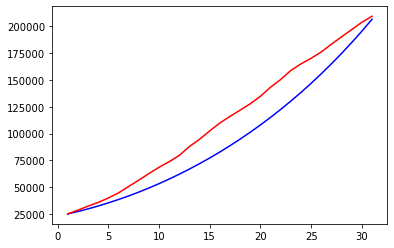

In [23]:
i=2
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.83497047010541e+18
1.3026362942764709e+17
7.473221071820365e+16
898487806328598.2
293737408056789.7
279152807017646.97
263237039174593.97
222774846296423.7
195852124792452.3
195330995987177.75
195330995987177.75
195330995987177.75
193442221202023.78
193442221202023.78
186421801203827.84
186421801203827.84
183247027829722.22
157899512319577.56
157899512319577.56
148473105730630.0
148473105730630.0
148473105730630.0
142133461899160.84
142133461899160.84
142133461899160.84
124530657005989.47
124530657005989.47
124530657005989.47
124530657005989.47
124530657005989.47
124530657005989.47
51067410660161.734
51067410660161.734
51067410660161.734
51067410660161.734
51067410660161.734
50136237428621.695
50132619140563.0
43978607079936.77
26613082491751.652
3139847063053.559
904943307140.2731
689129125375.8306
689129125375.8306
636388202297.3126
615836338403.7294
597700213791.6754
597700213791.6754
487268254017.0842
487268254017.0842
454177877371.61084
454177877371.61084
454177877371.61084
4515

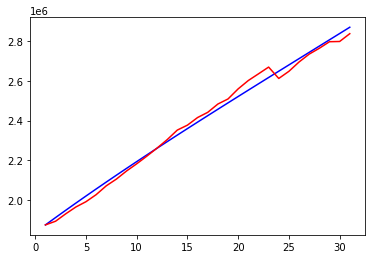

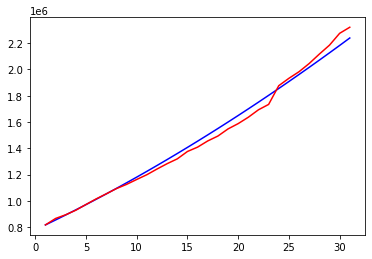

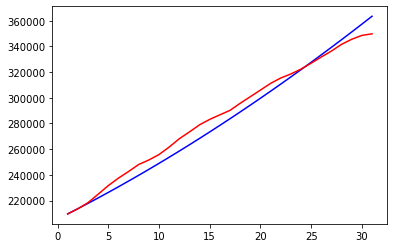

In [24]:
i=3
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.2163984246007123e+17
1.0192904064600702e+16
4834945326753957.0
533430255545580.6
431828920462241.25
415536657879727.06
339608866535596.3
338557926875385.6
326823933539378.06
266481488618981.88
241289223193472.25
239823580235204.03
232184843552298.0
232184843552298.0
207704385427411.38
207398773849083.2
201646997895038.94
201646997895038.94
198921745960158.5
179762364393235.5
179687003117089.97
179687003117089.97
179687003117089.97
141882780234502.25
136942797151875.61
104273023413884.42
104273023413884.42
104273023413884.42
84513218499563.12
84513218499563.12
75184561621413.61
29468018778689.19
29468018778689.19
29093886394776.75
12576477061607.473
7078848457325.87
6970791009048.375
2799471247354.7017
2799380287097.041
2130316980942.6504
1538558331344.7356
1538558331344.7356
1538558331344.7356
1538558331344.7356
1538558331344.7356
1538558331344.7356
1257013986904.7156
1169025428119.303
1169025428119.303
1169025428119.303
1134277045572.4775
1134277045572.4775
1068114323311.7993
106811

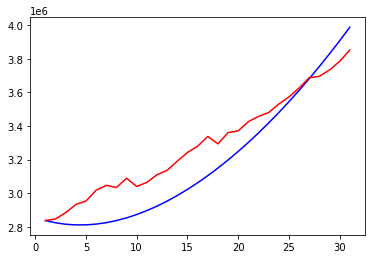

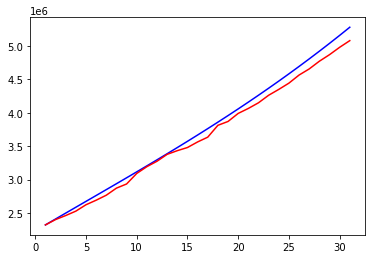

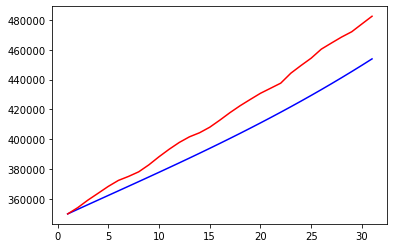

In [25]:
i=4
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.371523536840188e+18
1.0202436415166144e+17
3.042766380541044e+16
8020881862698517.0
876803142945831.8
847136551524987.6
742097243137595.6
741898241968261.5
741454715282914.6
741454715282914.6
741454715282914.6
741454715282914.6
741454715282914.6
741454715282914.6
741454715282914.6
741454715282914.6
741412925654598.0
741242036236762.2
741242036236762.2
741242036236762.2
741242036236762.2
723062506031337.0
716164833412476.2
716164833412476.2
716164833412476.2
716164833412476.2
550559935340616.56
550555879261545.56
544215171052950.2
446974384188600.6
446974384188600.6
238923686610906.88
238923686610906.88
154753317761850.66
133793878830075.22
115096427747082.95
104778636276980.88
33050275197118.16
21671424887362.27
21671424887362.27
12185326773152.48
595970663990.357
594225855879.584
547749750977.5735
531260071212.3484
531260071212.3484
391988274285.8802
391988274285.8802
260118025529.85114
260118025529.85114
259607312878.11636
222495937277.31323
220649258784.5973
218170832783.25958
212

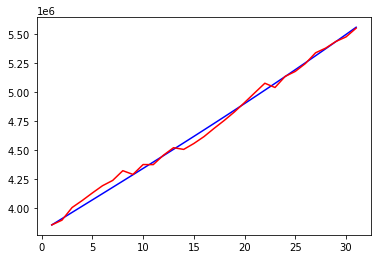

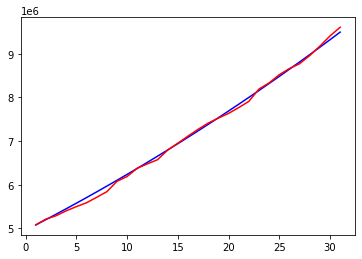

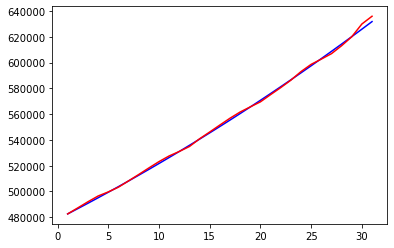

In [26]:
i=5
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.9775045680276603e+18
1.4958454190992426e+17
6.526534357343112e+16
1.3937856440945368e+16
1659432386269706.8
1530282753218093.0
1376533983043086.0
1347494138147686.8
1347438624880583.2
1347391016783073.8
1347391016783073.8
1344670048796098.2
1344670048796098.2
1344670048796098.2
1344670048796098.2
1344647766893331.0
1322611748641562.0
1322611748641562.0
1322611748641562.0
1197301809309925.5
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1158384813526822.0
1067812987796154.6
1067812987796154.6
1067812987796154.6
1067812987796154.6
1067812987796154.6
1067812987796154.6
1067812987796154.6
1067812987796154

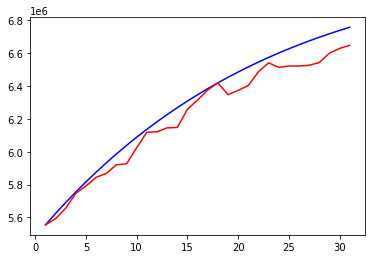

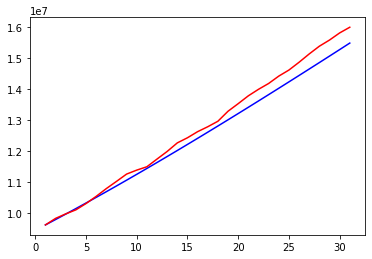

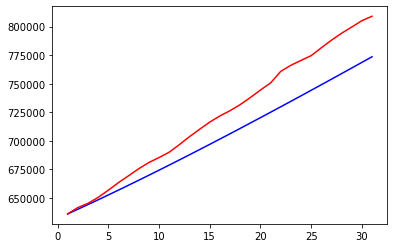

In [27]:
i=6
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.0217716568996246e+17
4.168066485950285e+16
1.909909467656088e+16
1.909909467656088e+16
3218381735920075.0
2335643410551880.5
2169870918733173.8
2107575009975020.5
2107575009975020.5
1855902775028793.5
1736051759226566.2
1680299671651129.2
1680299671651129.2
1669067341396581.2
1669067341396581.2
1669067341396581.2
1666751864800206.8
1645854534962738.5
1645854534962738.5
1589235911310840.2
1589235911310840.2
1589235911310840.2
1483948210366777.5
1473541456281327.5
1473541456281327.5
1449570249709202.8
1420360515388284.5
1418572706982934.5
1418572706982934.5
1418572706982934.5
1418572706982934.5
1418572706982934.5
1418572706982934.5
1415248893121642.2
1138587654962698.2
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
805024447675016.0
635357747812435.2
635357747812435.2
635357747812435.2
530242655444966.0
234192402889940.4
232025088515273.56
92961714348181.0
27367010297969.33
13941992987847.7

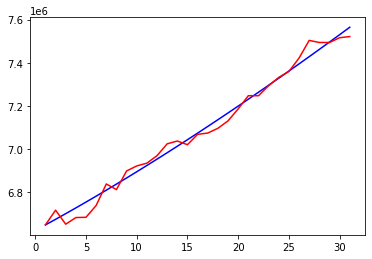

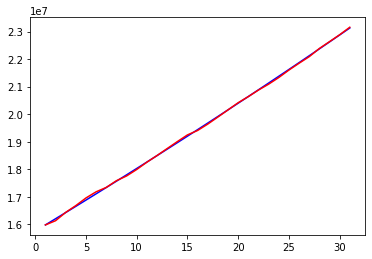

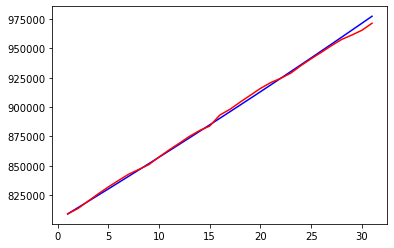

In [28]:
i=7
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

4.998155506957859e+17
4.86835018474568e+16
3.553865724577125e+16
2.891654714697664e+16
1.9651587348792824e+16
1.4357258825058288e+16
8663414036490694.0
7296142092060409.0
5842366718114656.0
4751345019978750.0
3051894980402778.0
2554538186705752.5
2521002594923129.0
2508311619256826.0
2454058111618642.5
2454058111618642.5
2394745648654637.5
2375003806400810.0
1980925589755865.0
1980900046637985.5
1969627074294211.0
1967732745272659.0
1967732745272659.0
1967732745272659.0
1967732745272659.0
1967732745272659.0
1734961881351531.5
1734961881351531.5
1734961881351531.5
1734961881351531.5
1734961881351531.5
1734961881351531.5
1719286824715322.5
1621070890969466.2
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
1392491110051915.5
915907946755324.4
682004480801625.1
521529204747728.2
184310216810895.84
183673693783474.22
15562996463172.418
1949502535022.3381
1854367266463.3416
1393792483779.9

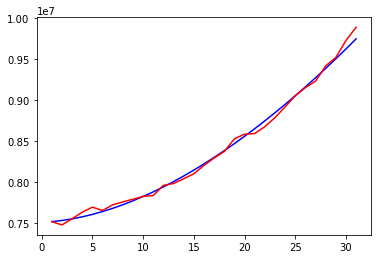

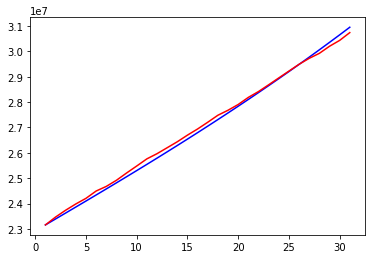

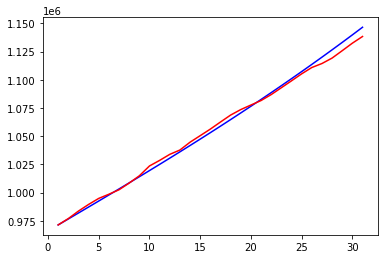

In [29]:
i=8
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.499566489368287e+18
6.552781677856944e+16
4.098745771693436e+16
1.0315447075817924e+16
6981241501462604.0
6787723002482392.0
6586288876034646.0
5764092370244304.0
5764092370244304.0
5678397412613077.0
5678397412613077.0
4878384384433495.0
4878384384433495.0
4625992924579042.0
2654833893925222.0
2612186679198935.0
2399141157300574.5
2399141157300574.5
2215135739421753.5
2215135739421753.5
2215135739421753.5
1992146722670008.0
1992146722670008.0
1698672989098872.8
1515979500232067.2
1392987333076890.0
858132002129021.8
712993400843480.0
576548993079840.0
245373247565609.94
158378998709187.78
128474449506096.69
119784335882286.97
70765071144512.94
44737176462900.11
24084812860915.49
8637374823333.439
7903487486331.322
4042149418226.918
3918886789248.1567
3918886789248.1567
3918886789248.1567
3918886789248.1567
3918886789248.1567
3883118700017.161
3883118700017.161
3821470540572.1465
3821470540572.1465
3821170224459.519
3667345678759.2266
3667345678759.2266
3667345678759.2266
36673456787

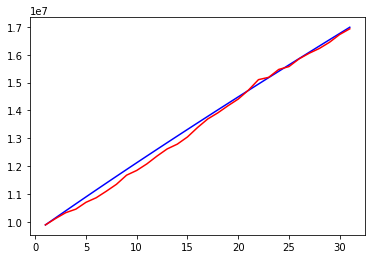

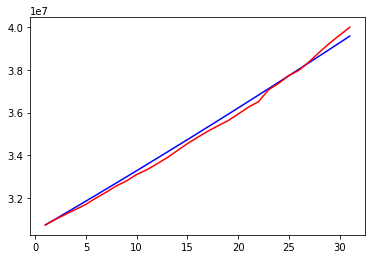

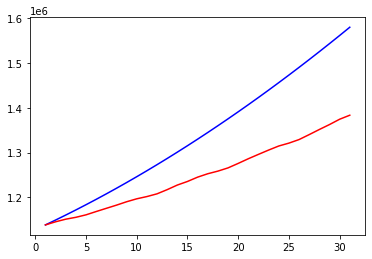

In [30]:
i=9
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.263448186849506e+18
1.8177290333938995e+17
1.7837284939140154e+16
1.4113357709496712e+16
1.4113357709496712e+16
1.4113357709496712e+16
1.3920226179626936e+16
1.3456333165412106e+16
1.3456333165412106e+16
1.312048187056551e+16
1.312048187056551e+16
1.312048187056551e+16
1.312048187056551e+16
1.312048187056551e+16
1.312048187056551e+16
1.312048187056551e+16
1.2910821429379602e+16
1.2910821429379602e+16
1.282639842947061e+16
1.2771812776036978e+16
1.2752416516780714e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.275241624884771e+16
1.2628114742190462e+16
1.2217631459680766e+16
1.2216823864889242e+16
1.221219265912021e+16
1.221219265912021e+16
1.221219265912021e+16
1.221219265912021e+16
1.221084606087669

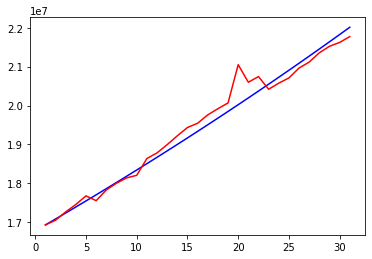

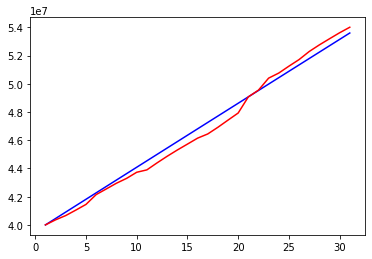

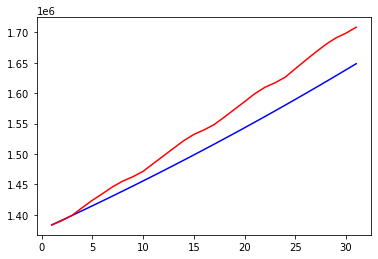

In [31]:
i=10
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2.6129516390620586e+19
3.0865276357127777e+18
1.396117378908234e+18
1.4767847045235936e+17
7.601241034061098e+16
6.794580789865514e+16
3.6571423953415064e+16
2.743711947342991e+16
2.7339079464278776e+16
2.0148741326437212e+16
1.9917882246383956e+16
7235398427822384.0
6471842613485240.0
2076825193827057.0
1885912315425479.2
1100057215154360.4
393841279252479.56
180522231667284.34
176763767686563.3
174935388470263.06
174935388470263.06
131963253216092.81
131963253216092.81
102307033111441.23
92589869949584.8
92589869949584.8
92589869949584.8
92589869949584.8
87226648992509.8
19624410034362.883
11668829497003.594
6638791729713.54
6206636089370.242
5909335489739.987
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5908692153279.458
5886735347706.168
5886735347706.168
5864796952707.392
5864796952707.392
5861399654414.105
5851214366033.612
5851214366033.612
5851214366033.612
5851214366033.612
58512

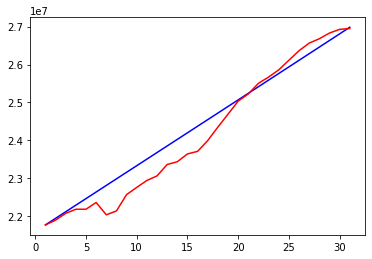

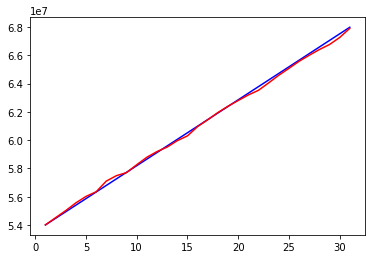

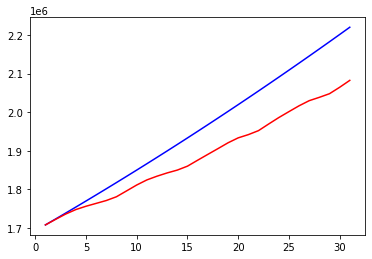

In [32]:
i=11
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.576565131095167e+19
1.2403828530067136e+17
5.96646993170866e+16
5.92841615700725e+16
5.88722632540546e+16
3.6263284756878e+16
3.452490525521914e+16
3.191904250578948e+16
3.191904250578948e+16
3.191904250578948e+16
3.0848103031794468e+16
3.0848103031794468e+16
3.0848103031794468e+16
2.843698792214835e+16
2.843698792214835e+16
2.843698792214835e+16
2.843698792214835e+16
2.843698792214835e+16
2.843698792214835e+16
2.8293239183892536e+16
2.828653805897911e+16
2.828653805897911e+16
2.828653805897911e+16
2.7407531114748696e+16
2.7407531114748696e+16
2.7407531114748696e+16
2.7407531114748696e+16
2.7407531114748696e+16
2.721231064122432e+16
2.721231064122432e+16
2.721231064122432e+16
2.034157006602532e+16
2.034157006602532e+16
2.034157006602532e+16
2.034157006602532e+16
2.034157006602532e+16
2.034157006602532e+16
1.5710288507891978e+16
1.554851707784327e+16
1.554851707784327e+16
1.554851707784327e+16
1.554851707784327e+16
7480998760693158.0
4539021509008229.0
2290174212373860.0
1565592901678

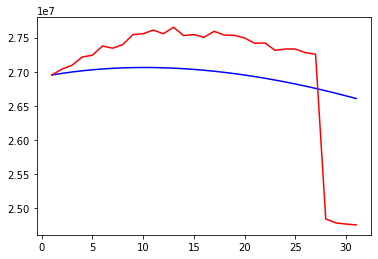

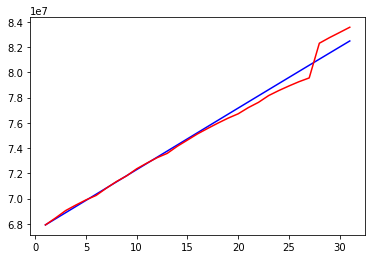

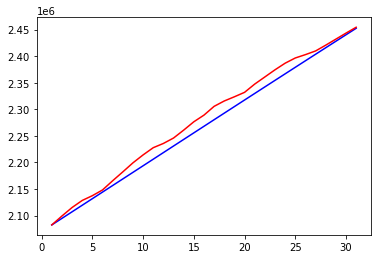

In [33]:
i=12
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

5.371069501157431e+18
2.4610715522334826e+17
1.0144735093128083e+17
7.202867771084592e+16
5.56598765559758e+16
3.0655576598376776e+16
2.8416730345650764e+16
2.543470890627791e+16
2.543470890627791e+16
2.543470890627791e+16
2.543470890627791e+16
2.447414023026557e+16
2.447414023026557e+16
2.4443691537458824e+16
2.4443691537458824e+16
2.4431776020258156e+16
2.421727334105589e+16
2.421727334105589e+16
2.421727334105589e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3726326865252484e+16
2.3005903710221044e+16
2.2946874490800704e+16
2.2929208948816908e+16
2.2929208948816908e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.188301654949149e+16
2.18830165

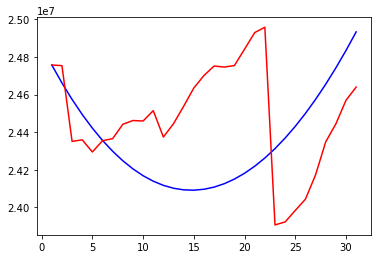

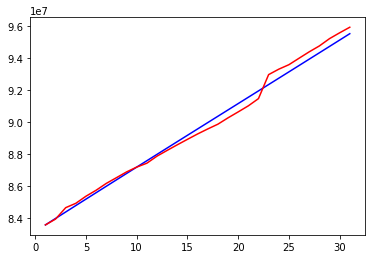

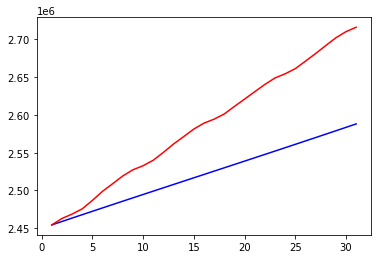

In [34]:
i=13
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

In [35]:
e0=predict.iloc[30,1]
print(e0)
def final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(6000):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def final_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=7585204179#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    print(n*0.00001)
    return predict

306183321.3011058


In [38]:
# canshu1=[[0.495513916015625, 0.0001220703125, 0.000152587890625, 0.006072998046875, 0.00091552734375]]
# canshu2=[[0.20306396484375, 0.000213623046875, 0.000274658203125, 0.01629638671875, 0.00018310546875]]
# canshu3=[[0.09930419921875, 0.0003662109375, 0.000335693359375, 0.0115966796875, 0.00048828125]]
final_result=final_yuce(0.16941397530692, 0.00668116978236607,306183321,0.00176130022321429, 0.0203988211495536, 14,0.0000130789620535714)

75852.04179


In [39]:
final_result.to_csv('final_Improve.csv',index=False)